1. Create the synthetic control using ridge regression (with cross-validation for hyperparameter tuning)
2. Assess pre-treatment balance of bet volume and state-level features between actual and synthetic units
3. Assess and plot short- and long-term treatment effect

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold

In [45]:
#import data
df = pd.read_csv('syntheticdat.csv')
covariate_df = pd.read_csv('state_covariates.csv')  # Make sure this CSV is ready!

In [91]:
# Define pre-treatment and post-treatment periods
promo_start_date = '2023-03-01'
states = ['NJ', 'PA', 'MI', 'IL']
control_states = ['PA', 'MI', 'IL']
treated_state = 'NJ'

# Prepare data
df['Date'] = pd.to_datetime(df['Date'])
df['PostTreatment'] = (df['Date'] >= pd.to_datetime(promo_start_date)).astype(int)

In [48]:
# Pivot for State X time dataset
# Outcome: Bet volume
handle_pivot = df.pivot(index='Date', columns='State', values='Handle')

# Split into pre- and post-treatment
pre_treatment = handle_pivot.loc[handle_pivot.index < promo_start_date]
post_treatment = handle_pivot.loc[handle_pivot.index >= promo_start_date]


In [49]:
# Make covariate matrix
covariates = covariate_df[covariate_df['State'].isin(states)].set_index('State')

# Select only numerical covariates
covariate_columns = [
    'Population', 'Median_Income', 'Unemployment_Rate',
    'Regulatory_Strictness', 'Population_Conservativeness',
    'Sports_Popularity_Index', 'Home_Team_Historical_Winrate'
]
covariates = covariates[covariate_columns]

#normalize
covariates = (covariates - covariates.mean()) / covariates.std()


In [56]:
# Design matrix
# For each control state, stack pre-treatment Handle series with covariates
X_controls = []
for state in control_states:
    # Stack outcome + covariates
    handle_series = pre_treatment[state].values  # (T_pre, )
    covariate_series = covariates.loc[state].values  # (K_covariates, )
    combined = np.concatenate([handle_series, covariate_series])  # (T_pre + K_covariates, )
    X_controls.append(combined)

X_controls = np.column_stack(X_controls)  # (T_pre + K_covariates, J_controls)

# Treated state's pre-treatment outcome + covariates
y_treated_handle = pre_treatment[treated_state].values  # (T_pre, )
y_treated_covariates = covariates.loc[treated_state].values  # (K_covariates, )
y_treated = np.concatenate([y_treated_handle, y_treated_covariates])  # (T_pre + K_covariates, )

print(f"Treated State: {treated_state}")
print(f"Shape of X_controls: {X_controls.shape}, Shape of y_treated: {y_treated.shape}")

Treated State: NJ
Shape of X_controls: (431, 3), Shape of y_treated: (431,)


In [57]:
# Ridge regression (w cross-validation) to estimate weights
# (create the optimal weights that minimize the difference between the synthetic control and the treated )
alpha_values = np.logspace(-6, 6, 13)  # Regularization values
ridge_cv = RidgeCV(alphas=alpha_values, store_cv_results=True, fit_intercept=False)
ridge_cv.fit(X_controls, y_treated)

best_alpha = ridge_cv.alpha_
print(f"\nBest alpha found by CV: {best_alpha:.4f}")

# Extract weights
weights_cv = ridge_cv.coef_
print("\n--- Synthetic Control Weights (Tuned Alpha with Covariates) ---")
for s, w in zip(control_states, weights_cv):
    print(f"{s}: {w:.4f}")




Best alpha found by CV: 1000000.0000

--- Synthetic Control Weights (Tuned Alpha with Covariates) ---
PA: 0.4909
MI: 0.4811
IL: 0.1830


In [58]:
# Synthetic control constructions
# Apply weights to post-treatment Handle
synthetic_nj_pre = np.dot(pre_treatment[control_states].values, weights_cv)  # (T_pre, )
synthetic_nj_post = np.dot(post_treatment[control_states].values, weights_cv)  # (T_post, )
synthetic_nj = np.concatenate([synthetic_nj_pre, synthetic_nj_post])

# Actual NJ data
actual_nj = handle_pivot[treated_state].values
dates = handle_pivot.index


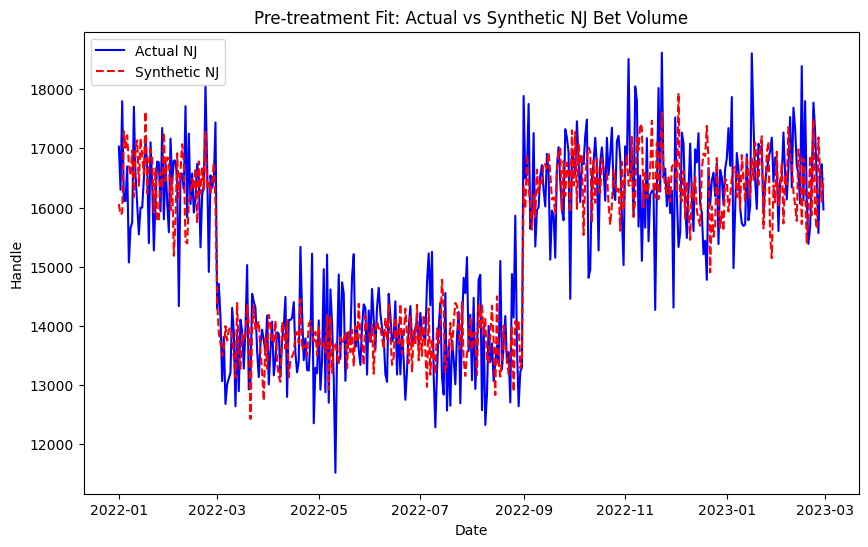

Pre-treatment MSE: 778982.6555
R-squared of Pre-treatment Fit: 0.6651


In [59]:
# Look at pre-streatment balance and fit
plt.figure(figsize=(10, 6))
plt.plot(dates[:len(pre_treatment)], actual_nj[:len(pre_treatment)], label='Actual NJ', color='blue')
plt.plot(dates[:len(pre_treatment)], synthetic_nj_pre, label='Synthetic NJ', color='red', linestyle='--')
plt.title("Pre-treatment Fit: Actual vs Synthetic NJ Bet Volume")
plt.legend()
plt.xlabel('Date')
plt.ylabel('Handle')
plt.show()

pre_treatment_mse = np.mean((actual_nj[:len(pre_treatment)] - synthetic_nj_pre) ** 2)
print(f"Pre-treatment MSE: {pre_treatment_mse:.4f}")
from sklearn.metrics import r2_score
r2 = r2_score(actual_nj[:len(pre_treatment)], synthetic_nj_pre)
print(f"R-squared of Pre-treatment Fit: {r2:.4f}")

In [84]:
# Example for evaluating balance on state-level covariates
import matplotlib.pyplot as plt
import numpy as np
# Covariates
covariates = ['Population', 'Median_Income', 'Regulatory_Strictness', 'Sports_Popularity_Index']

# Calculate the treated state (NJ) mean values
treated_values = [df[df['State'] == 'NJ'][covariate].mean() for covariate in covariates]

# Calculate the synthetic control values (weighted sum) for each covariate
synthetic_values = []
for covariate in covariates:
    # Aggregate control values across time for each covariate
    control_values = df[df['State'].isin(control_states)].groupby('State')[covariate].mean().values
    # Compute the weighted average for the synthetic control (scalar value)
    synthetic_value = np.dot(weights_cv, control_values)  # Apply weights to aggregated control state values
    synthetic_values.append(synthetic_value)


In [85]:
print(synthetic_values)
print(treated_values)

[np.float64(12064423.085822098), np.float64(69974.49867443508), np.float64(3.9363092784956164), np.float64(0.790724164775436)]
[np.float64(11363131.054022549), np.float64(45336.653420928276), np.float64(2.0), np.float64(0.5516083244394999)]


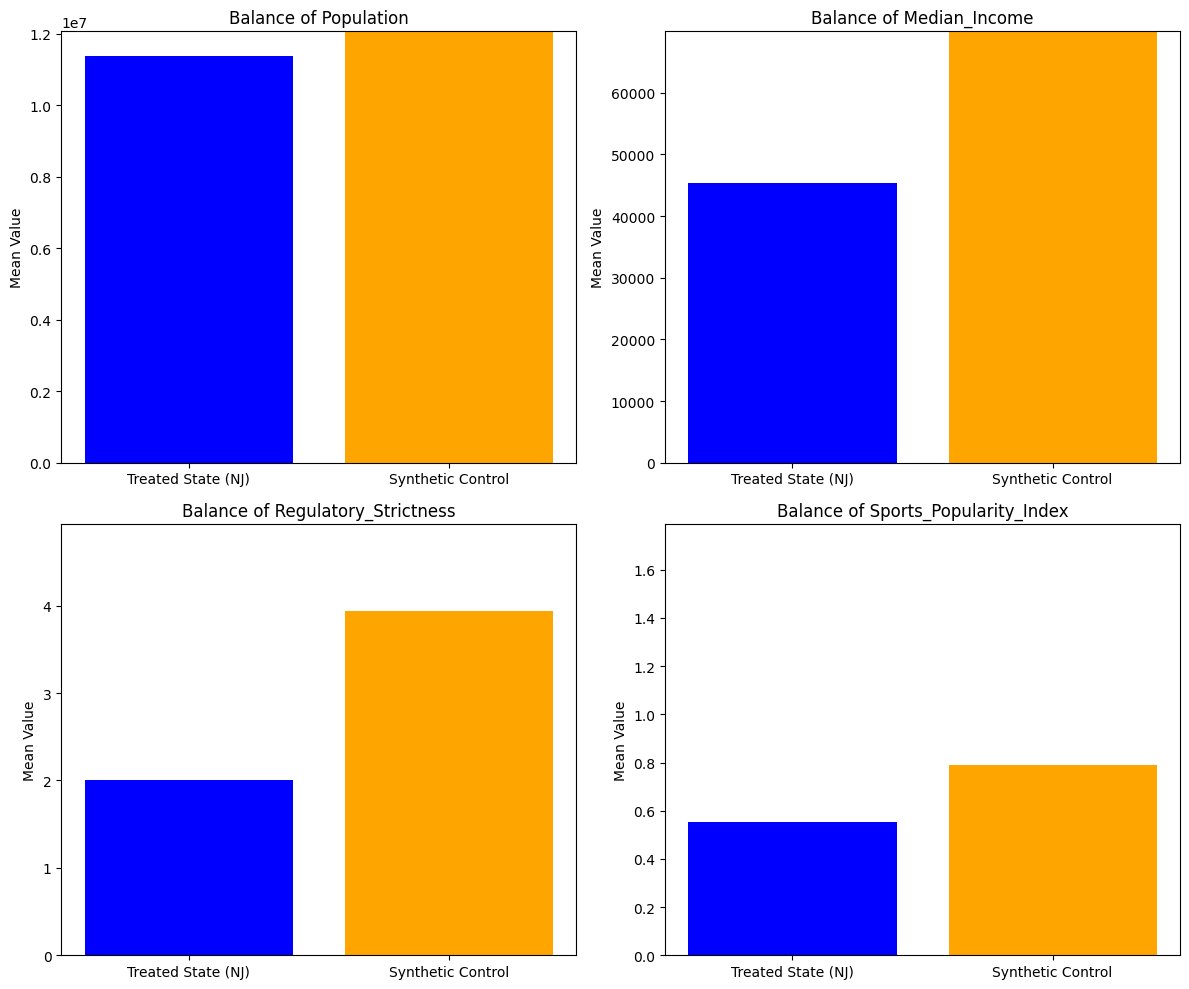

In [87]:
# Create a figure with subplots (4 separate plots in a 2x2 grid)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# Flatten axs for easy iteration
axs = axs.flatten()

# Plot each covariate on a separate subplot
for i, covariate in enumerate(covariates):
    # Ensure scalar values for plotting
    axs[i].bar(['Treated State (NJ)', 'Synthetic Control'], [float(treated_values[i]), float(synthetic_values[i])], color=['blue', 'orange'])
    axs[i].set_title(f'Balance of {covariate}')
    axs[i].set_ylabel('Mean Value')
    
    # Set the y-axis limits to start from 0 and adjust the upper limit dynamically
    axs[i].set_ylim(0, max(float(treated_values[i]), float(synthetic_values[i])) + 1)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [88]:
# Make results df
results_df = pd.DataFrame({
    'Date': dates,
    'Actual_NJ_Handle': actual_nj,
    'Synthetic_NJ_Handle': synthetic_nj
})

In [92]:
print(results_df['Date'].min(), results_df['Date'].max()) 
print(promo_start_date) 
print(results_df.head())


2022-01-01 00:00:00 2023-06-30 00:00:00
2023-03-01
        Date  Actual_NJ_Handle  Synthetic_NJ_Handle  Treatment_Effect
0 2022-01-01      17028.645754         16057.987580        970.658174
1 2022-01-02      16301.369502         15880.122951        421.246551
2 2022-01-03      17796.896249         15911.346727       1885.549522
3 2022-01-04      16107.294599         17292.561181      -1185.266581
4 2022-01-05      16112.289700         17009.583053       -897.293353


In [94]:
# Get short-term and long-term results
results_df.to_csv('synthetic_control_results.csv', index=False)
print(results_df)

# pointwise treatment effect
results_df['Treatment_Effect'] = results_df['Actual_NJ_Handle'] - results_df['Synthetic_NJ_Handle']

# Define timeframe
promo_start_date = pd.to_datetime(promo_start_date) 
short_term_days = 14  # First 14 days as short-term

results_df['Date'] = pd.to_datetime(results_df['Date'])
post_treatment_df = results_df[results_df['Date'] >= promo_start_date]

# Short-term and long-term windows
short_term_df = post_treatment_df[post_treatment_df['Date'] < promo_start_date + pd.Timedelta(days=short_term_days)]
long_term_df = post_treatment_df[post_treatment_df['Date'] >= promo_start_date + pd.Timedelta(days=short_term_days)]

print(post_treatment_df.shape)  
print(short_term_df.shape)     
print(long_term_df.shape)      


          Date  Actual_NJ_Handle  Synthetic_NJ_Handle  Treatment_Effect
0   2022-01-01      17028.645754         16057.987580        970.658174
1   2022-01-02      16301.369502         15880.122951        421.246551
2   2022-01-03      17796.896249         15911.346727       1885.549522
3   2022-01-04      16107.294599         17292.561181      -1185.266581
4   2022-01-05      16112.289700         17009.583053       -897.293353
..         ...               ...                  ...               ...
541 2023-06-26      18210.262186         13404.144677       4806.117510
542 2023-06-27      18789.529407         14061.904456       4727.624950
543 2023-06-28      17637.580061         13785.354186       3852.225875
544 2023-06-29      17805.049323         13310.092975       4494.956348
545 2023-06-30      18519.122945         13124.172183       5394.950761

[546 rows x 4 columns]
(122, 4)
(14, 4)
(108, 4)


In [95]:

# Get Average Treatment Effect (ATE) for both periods
short_term_ATT = short_term_df['Treatment_Effect'].mean()
long_term_ATT = long_term_df['Treatment_Effect'].mean()

# Get Total cumulative effects
short_term_cumulative = short_term_df['Treatment_Effect'].sum()
long_term_cumulative = long_term_df['Treatment_Effect'].sum()

# Print results
print(f"\n--- Treatment Effects ---")
print(f"Short-term ATT (first {short_term_days} days): {short_term_ATT:.2f}")
print(f"Long-term ATT (after {short_term_days} days): {long_term_ATT:.2f}")

print(f"\nCumulative Short-term Effect: {short_term_cumulative:.2f}")
print(f"Cumulative Long-term Effect: {long_term_cumulative:.2f}")



--- Treatment Effects ---
Short-term ATT (first 14 days): 4096.88
Long-term ATT (after 14 days): 4449.56

Cumulative Short-term Effect: 57356.27
Cumulative Long-term Effect: 480552.23


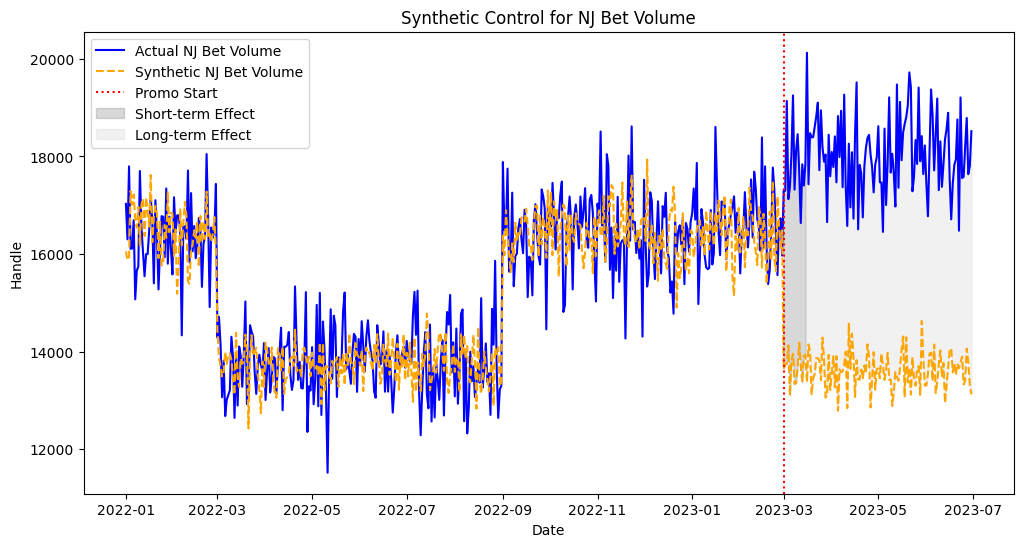

In [102]:
# Visualization
short_term_end_date = promo_start_date + pd.Timedelta(days=short_term_days)  # 14 days for short-term
long_term_start_date = short_term_end_date  # Long-term starts after short-term

plt.figure(figsize=(12, 6))

plt.plot(results_df['Date'], results_df['Actual_NJ_Handle'], label='Actual NJ Bet Volume', color='blue')
plt.plot(results_df['Date'], results_df['Synthetic_NJ_Handle'], label='Synthetic NJ Bet Volume', color='orange', linestyle='--')

plt.axvline(pd.to_datetime(promo_start_date), color='red', linestyle=':', label='Promo Start')

# Add shaded area for the short-term effect period (14 days)
plt.fill_between(results_df['Date'], 
                 results_df['Synthetic_NJ_Handle'], results_df['Actual_NJ_Handle'], 
                 where=(results_df['Date'] >= promo_start_date) & (results_df['Date'] <= short_term_end_date),
                 color='grey', alpha=0.3, label='Short-term Effect')

# Add shaded area for the long-term effect period (after short-term)
plt.fill_between(results_df['Date'], 
                 results_df['Synthetic_NJ_Handle'], results_df['Actual_NJ_Handle'], 
                 where=(results_df['Date'] >= long_term_start_date), 
                 color='lightgrey', alpha=0.3, label='Long-term Effect')


# Customize labels and title
plt.legend()
plt.title('Synthetic Control for NJ Bet Volume')
plt.xlabel('Date')
plt.ylabel('Handle')

plt.savefig('synthetic_control_results.png', format='png')

# Show plot
plt.show()